# Pedestal

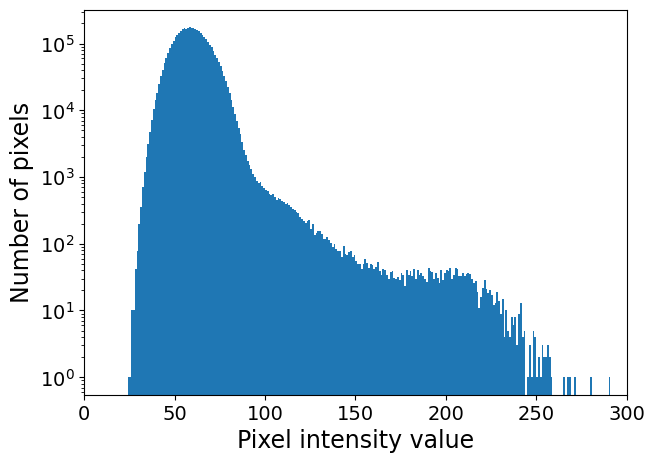

In [1]:
import numpy as np
from histograms import make_histogram

img = np.load("data/images/image8.npy")

# Create a histogram of the image
bin_centres, hist = make_histogram(img, -1)

# Plot the histogram
import matplotlib.pyplot as plt

plt.rc("axes", titlesize=17)
plt.rc("axes", labelsize=17)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)


plt.figure(figsize=(7,5))
plt.bar(bin_centres, hist, width = bin_centres[1]-bin_centres[0])
plt.yscale("log")
plt.xlabel("Pixel intensity value")
plt.ylabel("Number of pixels")
plt.xlim(0,300)
plt.savefig("pixel_count_histogram.svg")




## Number of photon hits in an image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram


img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)

In [3]:
spc.n_single_hits + 2*spc.n_double_hits

13806

In [4]:
13500/(2048**2) * 100

0.3218650817871094

## Temperature

See `/Configure:0000/Run:0000/CalibCycle:0008/Princeton::FrameV2/SxrEndstation.0:Princeton.0/frame`

# Bragg

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram


img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)


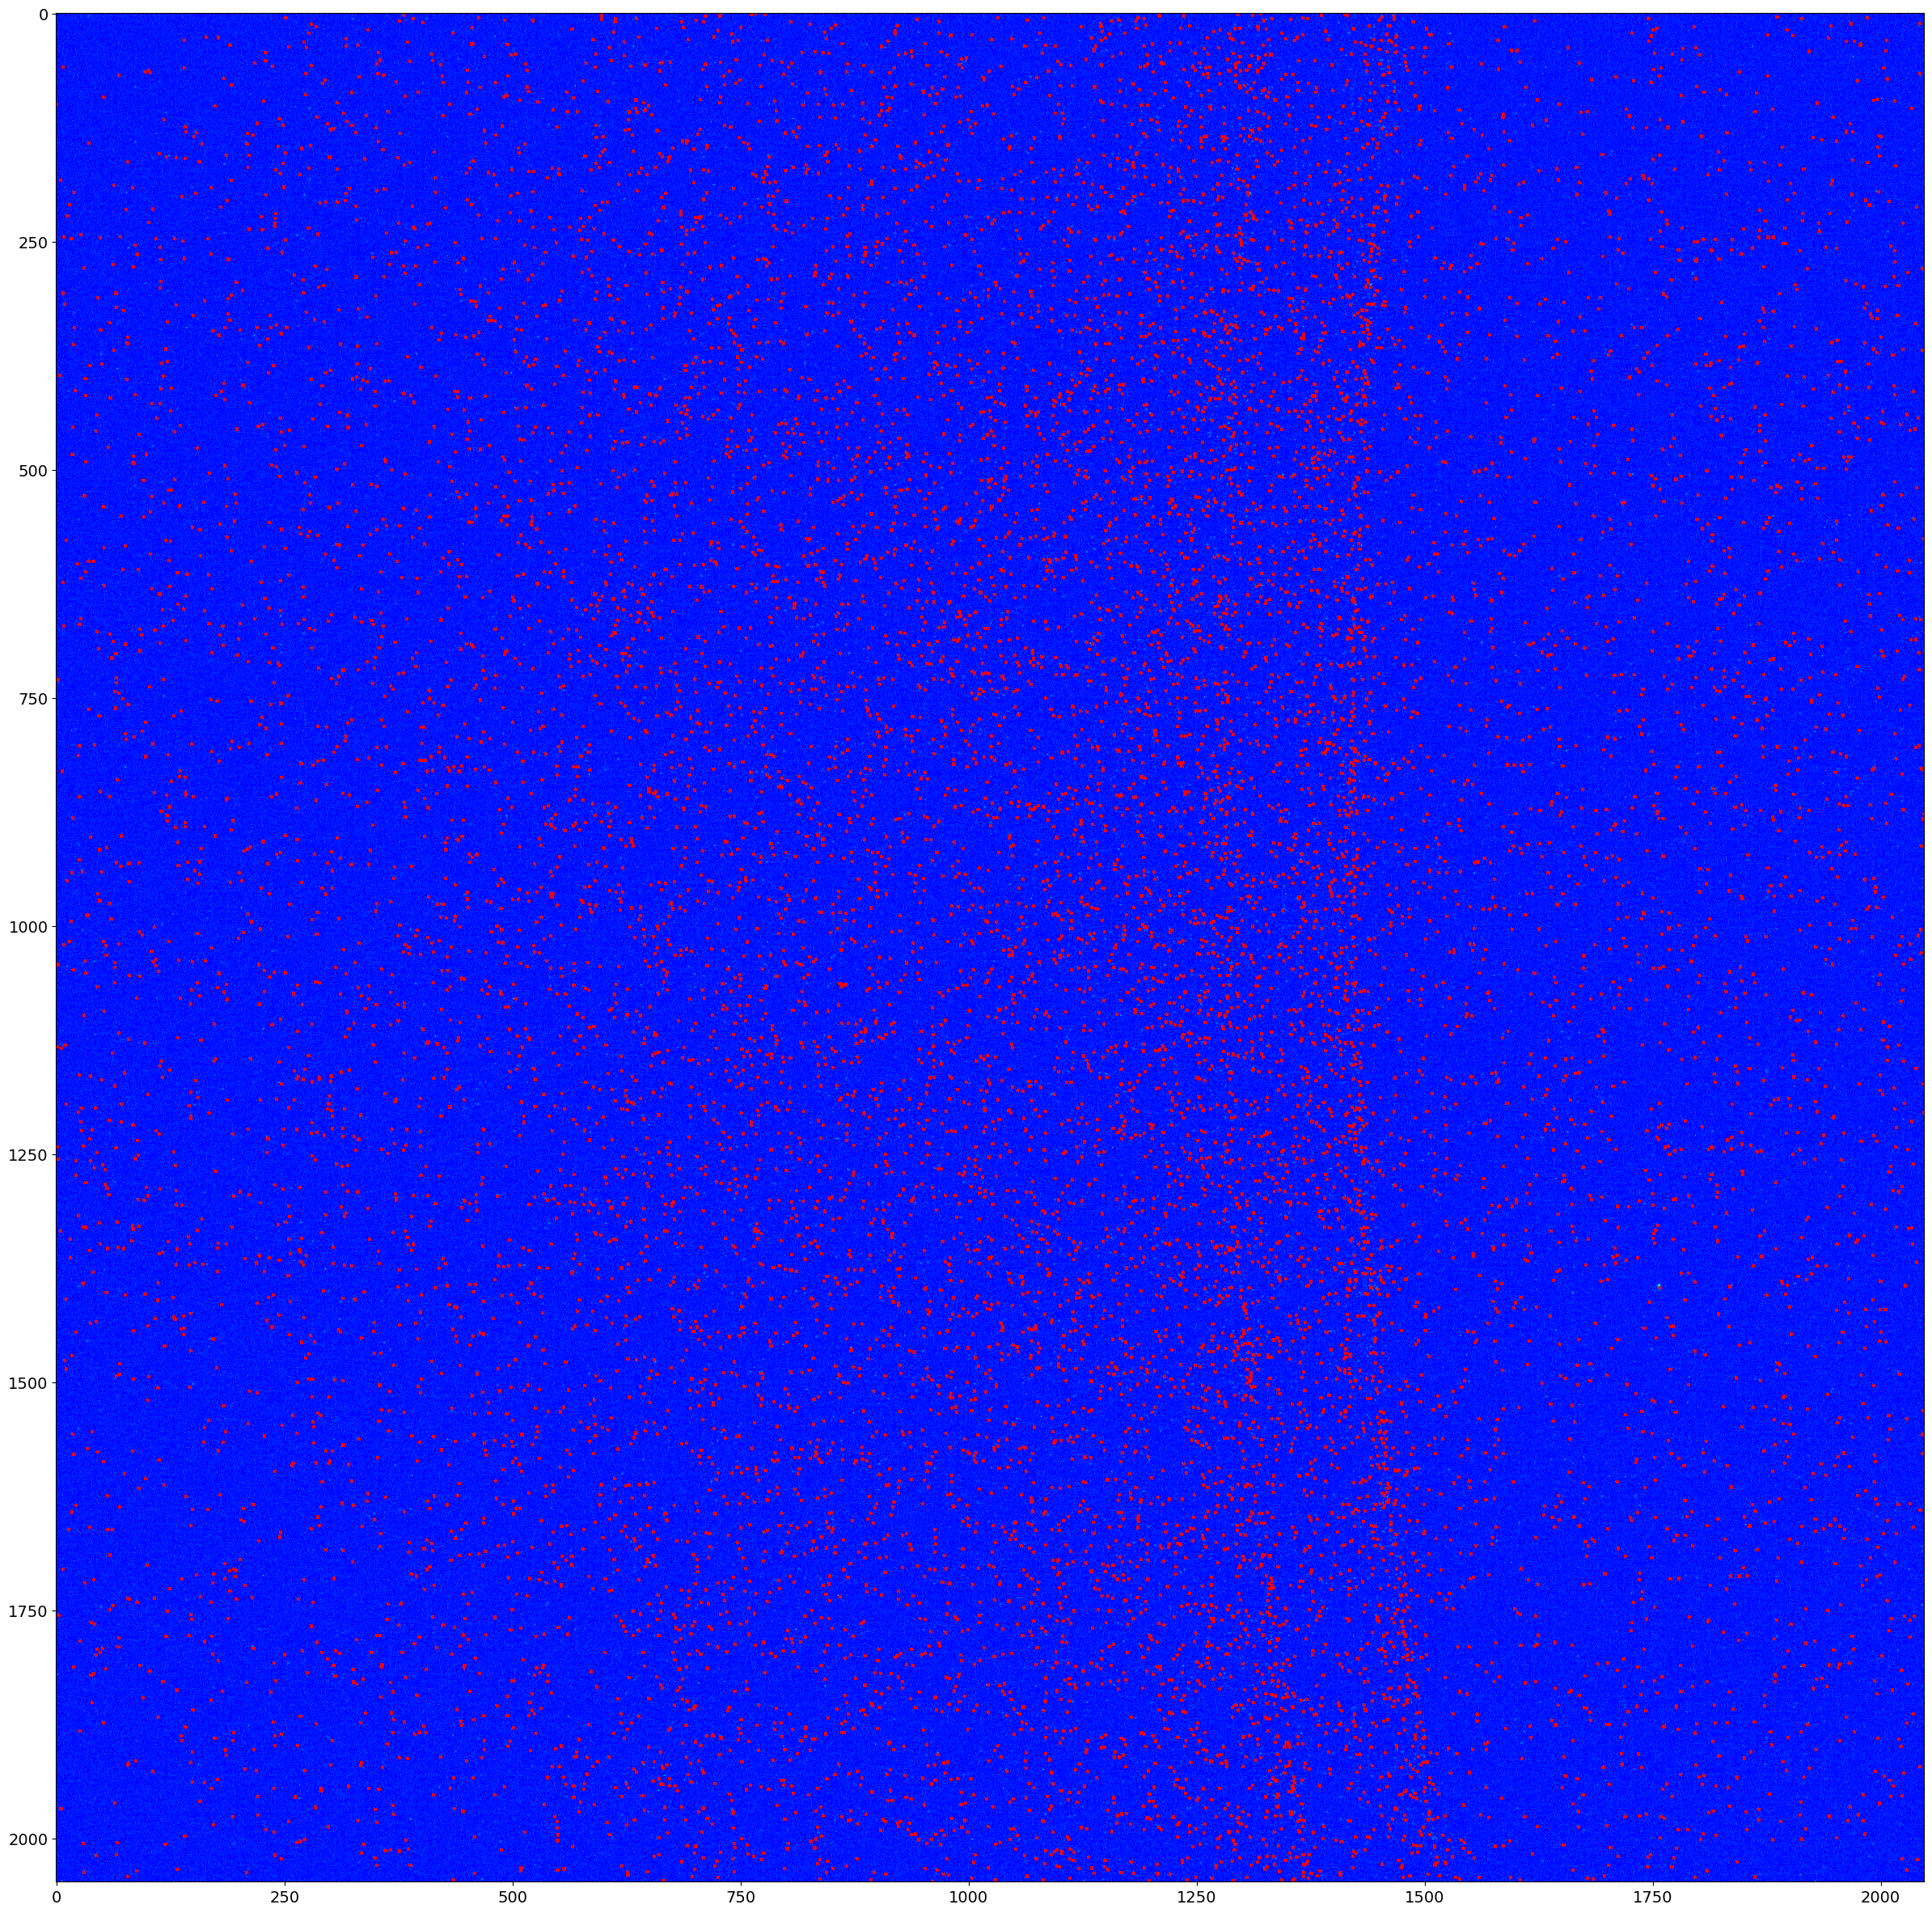

In [6]:
plt.figure(figsize = (30,30))
plt.imshow(spc.img, cmap="jet")

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((y-.5, x-.5), 1,1, fill=False, linewidth=2, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect



for loc in spc.all_hit_locations:
    highlight_cell(*loc, color="r")

plt.savefig("spc_hit_locations.svg")


In [7]:
hit_img = np.zeros_like(spc.img)

hit_size = 7

for loc, val in zip(spc.all_hit_locations, spc.all_hit_values):
    hit_img[int(loc[0]-hit_size//2):int(loc[0] + hit_size//2), int(loc[1]-hit_size//2):int(loc[1] + hit_size//2)] = val

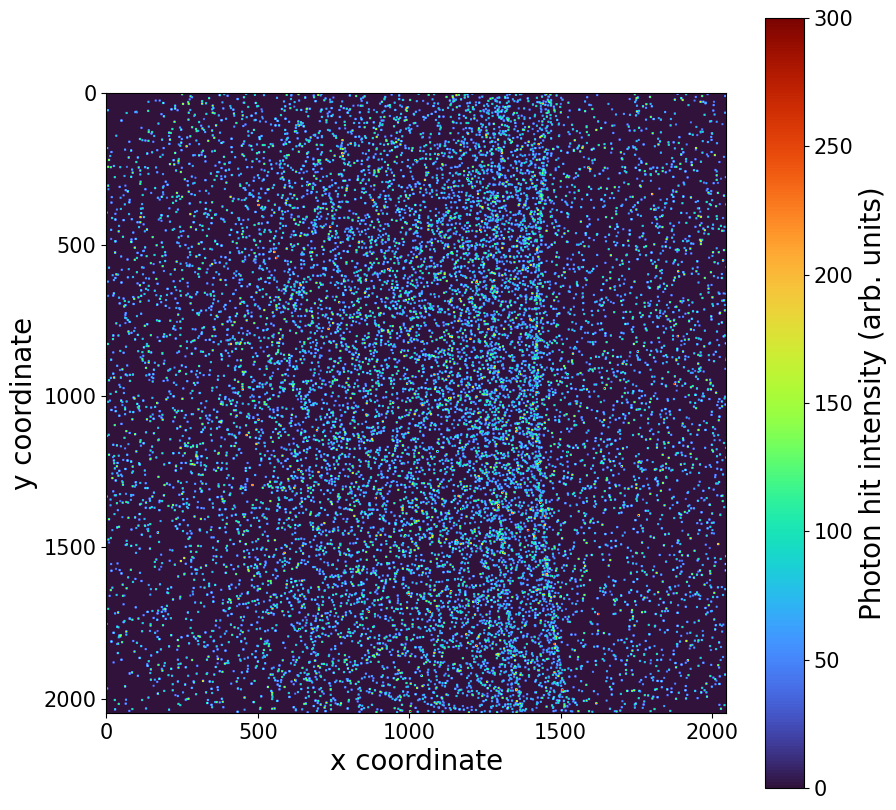

In [8]:

plt.rc("axes", titlesize=20)
plt.rc("axes", labelsize=20)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

plt.figure(figsize = (10,10))
plt.imshow(np.clip(hit_img, 0, 300), cmap="turbo")
plt.xticks([0,500,1000,1500,2000])
plt.yticks([0,500,1000,1500,2000][::-1])
plt.ylabel("y coordinate")
plt.xlabel("x coordinate")
plt.colorbar(label="Photon hit intensity (arb. units)")

plt.savefig("spc_hit_locations.svg", bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

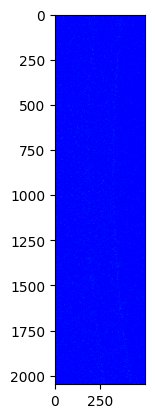

In [17]:
plt.imshow(spc.img[:,1100:1600], cmap="jet", color = "red")

## Edge detection kernel

### New kernel

In [3]:
import numpy
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

img = numpy.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)
em = EnergyMap(spc.img, 200, 200, 20, 2, 100, (25, 25), [1218.5, 1188.0])

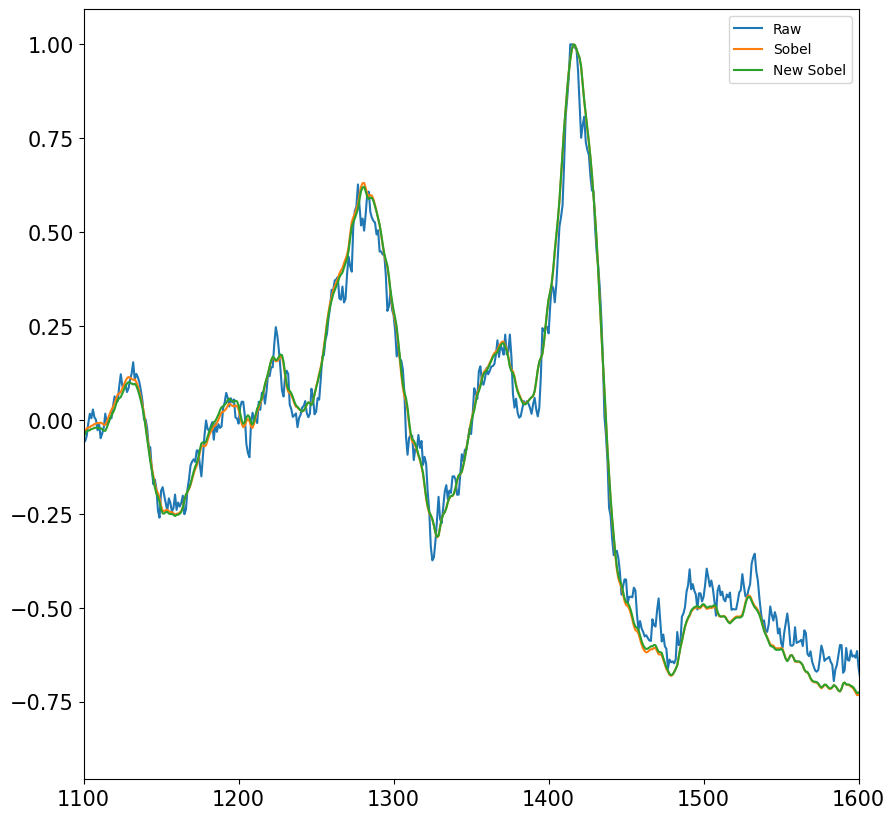

In [59]:
from bragg import make_lineout, convolve_image
from scipy.ndimage import gaussian_filter, gaussian_gradient_magnitude
import numpy as np
import numpy as np

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

def new_sobel_matrix(size):
    x = sp.symbols("x")
    row = np.array(sp.Poly(sp.expand(((x+1)**(size-2))*(x-1))).all_coeffs()[::-1], dtype = np.float64)
    col = gaussian(np.arange(size), size//2, size/4).reshape(-1, 1)

    return row*col


new_sobel = np.abs(new_sobel_matrix(25))

raw = make_lineout(em.img, 1000, 200, 25)
sobel_conv = make_lineout(em.convolved_img, 1000, 200, 25)
new_sobel_conv = make_lineout(convolve_image(em.img, new_sobel), 1000, 200, 25)

plt.figure(figsize = (10,10))
plt.plot(raw/raw.max(), label="Raw")
plt.plot(sobel_conv/sobel_conv.max(), label="Sobel")
#plt.plot(gauss_conv/gauss_conv.max(), label="Gaussian gradient")
plt.plot(new_sobel_conv/new_sobel_conv.max(), label="New Sobel")
plt.xlim(1100,1600)
plt.legend()


In [55]:
import sympy as sp
import numpy as np
from math import comb

def new_sobel_matrix(size):
    x = sp.symbols("x")
    row = np.array(sp.Poly(sp.expand(((x+1)**(size-2))*(x-1))).all_coeffs()[::-1], dtype = np.float64)

    return row

def new_sobel_2(size):
    sobel = np.zeros(size)

    n=size-2

    for i in range(1,n+1):

        sobel[i] = comb(n,i-1) - comb(n,i)

    sobel[0] = -1
    sobel[-1] = 1
    return sobel

new_sobel_matrix(11), new_sobel_2(11)

(array([ -1.,  -8., -27., -48., -42.,   0.,  42.,  48.,  27.,   8.,   1.]),
 array([ -1.,  -8., -27., -48., -42.,   0.,  42.,  48.,  27.,   8.,   1.]))

In [62]:
size=9
col = gaussian(np.arange(size) - size//2, 0, size/4)

col, gaussian(np.arange(size), size//2, size/4)

(array([0.03651195, 0.07289337, 0.11944127, 0.16063281, 0.17730768,
        0.16063281, 0.11944127, 0.07289337, 0.03651195]),
 array([0.03651195, 0.07289337, 0.11944127, 0.16063281, 0.17730768,
        0.16063281, 0.11944127, 0.07289337, 0.03651195]))

In [80]:
# generate a sobel matrix of arbitrary size
from scipy.ndimage import gaussian_filter1d
import numpy as np
import sympy as sp

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

def new_sobel_matrix(size):
    x = sp.symbols("x")
    row = np.array(sp.Poly(sp.expand(((x+1)**(size-2))*(x-1))).all_coeffs()[::-1], dtype = np.float64)
    col = gaussian(np.arange(size) - size//2, 0, 1).reshape(-1, 1)

    return row*col


new_sobel_matrix(5)

array([[-0.05399097, -0.10798193,  0.        ,  0.10798193,  0.05399097],
       [-0.24197072, -0.48394145,  0.        ,  0.48394145,  0.24197072],
       [-0.39894228, -0.79788456,  0.        ,  0.79788456,  0.39894228],
       [-0.24197072, -0.48394145,  0.        ,  0.48394145,  0.24197072],
       [-0.05399097, -0.10798193,  0.        ,  0.10798193,  0.05399097]])

In [77]:
import sympy as sp

x = sp.symbols("x")
k = 3
sp.Poly(sp.expand(((x+1)**(k-2))*(x-1))).all_coeffs()

[1, 0, -1]

In [75]:

np.array(sp.Poly(sp.expand(((x+1)**(k-2))*(x-1))).coeffs()[::-1])


array([-1, 1], dtype=object)

### Making the figure

In [2]:
import numpy
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

img = numpy.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5, fit_hits=False)

In [3]:
em = EnergyMap(spc.img, 200, 200, 20, 2, 100, 25, [1218.5, 1188.0])

Uncertainties due to peak uncertainties: [ 1.73466171e+01 -1.01996181e+01 -1.43304250e+05  4.15483083e-03]
Uncertainties due to fitting process: [2.30075785e+00 1.31113040e+00 2.06824631e+04 2.23759941e-03]


In [4]:
from bragg import make_lineout

raw = make_lineout(em.img, 1000, 200, 25)
sobel_conv = make_lineout(em.convolved_img, 1000, 200, 25)

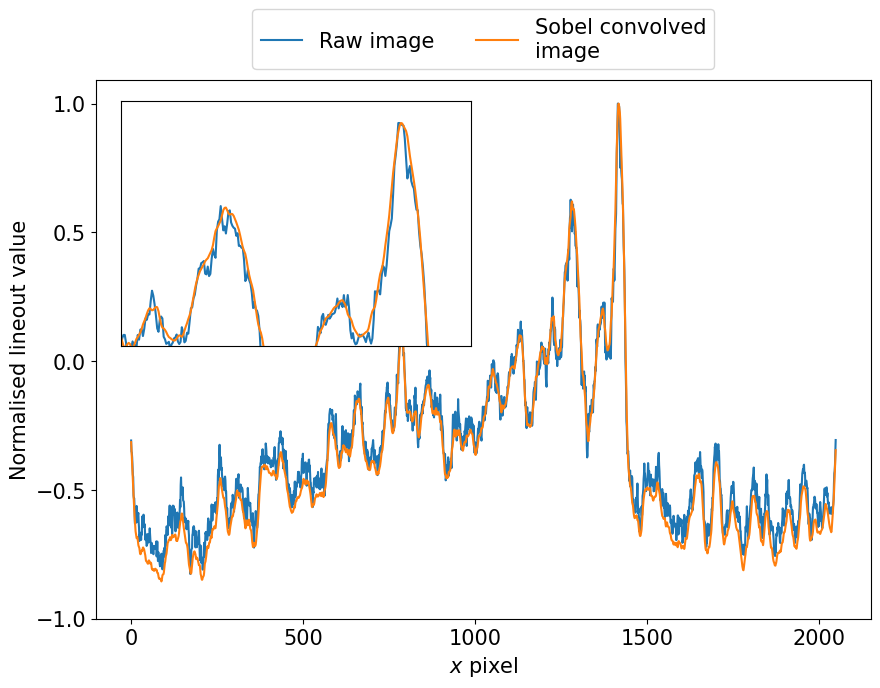

In [7]:
fig, ax1 = plt.subplots(figsize=(10,7))

ax1.plot(raw/raw.max(), label="Raw image")
ax1.plot(sobel_conv/sobel_conv.max(), label="Sobel convolved\nimage")
ax1.legend(fontsize=15, loc="upper center", bbox_to_anchor = (0.5,1.15), ncols=2)

left, bottom, width, height = [0.15,0.5,0.35,0.35]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(raw/raw.max(), label="Raw")
ax2.plot(sobel_conv/sobel_conv.max(), label="Sobel")
ax2.set_xlim(1200,1470)
ax2.set_ylim(0.0,1.1)
ax2.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,
    labelleft=False)
ax2.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

ax1.set_xlabel("$x$ pixel")
ax1.set_ylabel("Normalised lineout value")
ax1.set_yticks([-1,-0.5,0,0.5,1])

plt.rc("axes", titlesize=15)
plt.rc("axes", labelsize=15)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

plt.savefig("lineout.svg", bbox_inches="tight")

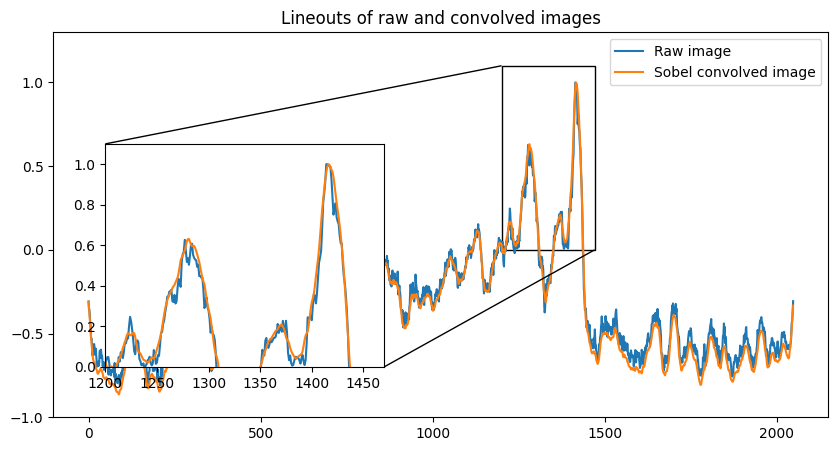

In [50]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax1 = plt.subplots(figsize=(10,5))



ax1.plot(raw/raw.max(), label="Raw image")
ax1.plot(sobel_conv/sobel_conv.max(), label="Sobel convolved image")
ax1.legend()
ax1.set_title("Lineouts of raw and convolved images")
ax1.set_ylim(-1,1.3)


axins = zoomed_inset_axes(ax1, 3, loc="upper left", bbox_to_anchor=[170,500]) # zoom-factor: 2.5, location: upper-left
axins.set_box_aspect(0.8)
axins.plot(raw/raw.max(), label="Raw")
axins.plot(sobel_conv/sobel_conv.max(), label="Sobel")
axins.set_xlim(1200,1470)
axins.set_ylim(0.0, 1.1)

mark_inset(ax1, axins, loc1=2, loc2=4)

plt.draw()
plt.show()


## Adding uncertainties

I will use the sd as an estimation for the uncertainty in the line location. To do this, I fit a gaussian to points within 50 pixels either side of the peak

[14.66133222550269, 9.768296344031649]

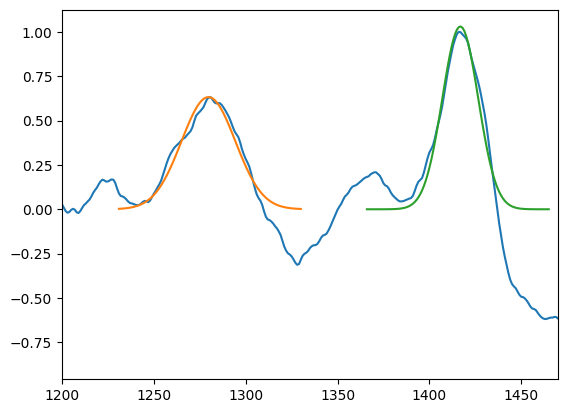

In [77]:
from bragg import locate_peaks
from scipy.optimize import curve_fit
import numpy as np

def gaussian(x: np.ndarray, a: float, mu: float, sigma: float) -> np.ndarray:
    """Return a Gaussian distribution with mean mu and standard deviation sigma"""
    return a / np.sqrt(2 * np.pi) / sigma * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

lineout = sobel_conv/sobel_conv.max()

locs, heights = locate_peaks(lineout, 2, 100)

fit_area_size = 50

fit_areas = [lineout[locs[i]-fit_area_size:locs[i]+fit_area_size] for i in range(len(locs))]


fit_params = [curve_fit(gaussian, np.arange(len(area)), area, p0=[1,25,1]) for area in fit_areas]

plt.plot(lineout)

for i in range(len(locs)):
    plt.plot(np.arange(locs[i]-fit_area_size,locs[i]+fit_area_size), gaussian(np.arange(fit_area_size*2), *fit_params[i][0]))

plt.xlim(1200,1470)

sds = [fit_params[i][0][2] for i in range(len(fit_params))]
sds


In [2]:
import numpy
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram
import warnings

warnings.filterwarnings("error")

img = numpy.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5, fit_hits=False)
em = EnergyMap(spc.img, 200, 200, 20, 2, 100, 25, [1218.5, 1188.0])
em.hyp_params

Uncertainties due to peak uncertainties: [ 1.23339757e+02 -7.24768114e+01 -1.00977301e+06  2.96461664e-02]
Uncertainties due to fitting process: [2.30075774e+00 1.31486188e+00 2.04839310e+04 2.21647998e-03]


array([-1.83481748e+03,  8.38889310e+02,  1.41793672e+07,  4.69718247e-01])

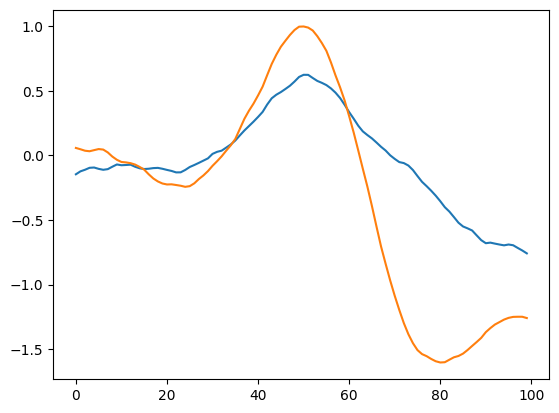

In [14]:
import numpy as np
from bragg import gaussian
from scipy.optimize import curve_fit
lineout = np.load("lineout.npy")
#plt.plot(lineout)
peak_locs = [1287, 1434]
fit_half_width = 50
fit_areas = [
        lineout[peak_locs[i] - fit_half_width : peak_locs[i] + fit_half_width]
        for i in range(len(peak_locs))
    ]
plt.plot(fit_areas[0])
plt.plot(fit_areas[1])
fit_params = [
            curve_fit(gaussian, np.arange(len(area)), area, p0=[1, fit_half_width, 1])
            for area in fit_areas
        ]




In [3]:
plt.plot(lineout)
plt.vlines()

NameError: name 'lineout' is not defined

# Results

## Single spectrum plot

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

signal_image_nums = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19]

all_imgs = [np.load(f"data/images/image{i}.npy") for i in signal_image_nums]
all_spcs = [SPC(img, 75, 30, 2, padding=2, fit_area_size=5) for img in all_imgs]

master_em = EnergyMap(spc.img, 200, 200, 20, 2, 100, 25, [1218.5, 1188.0])

Uncertainties due to peak uncertainties: [ 1.23339757e+02 -7.24768114e+01 -1.00977301e+06  2.96461664e-02]
Uncertainties due to fitting process: [2.30075774e+00 1.31486188e+00 2.04839310e+04 2.21647998e-03]


In [42]:
from bragg import Spectrum

all_spectra = [Spectrum(spc, master_em, 3, 1100, 1600) for spc in all_spcs]
all_spectra = sorted(all_spectra, key = lambda x: x.counts.mean())

Text(0.5, 0, 'Energy (eV)')

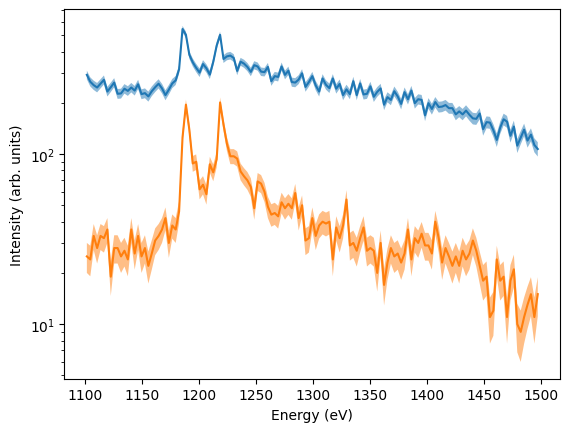

In [26]:
spectrum = all_spectra[-1]
plt.plot(spectrum.bin_centers, spectrum.counts)
plt.fill_between(spectrum.bin_centers, spectrum.counts - spectrum.count_uncs, spectrum.counts + spectrum.count_uncs, alpha=0.5)
spectrum = all_spectra[0]
plt.plot(spectrum.bin_centers, spectrum.counts)
plt.fill_between(spectrum.bin_centers, spectrum.counts - spectrum.count_uncs, spectrum.counts + spectrum.count_uncs, alpha=0.5)

plt.yscale("log")
plt.ylabel("Intensity (arb. units)")
plt.xlabel("Energy (eV)")

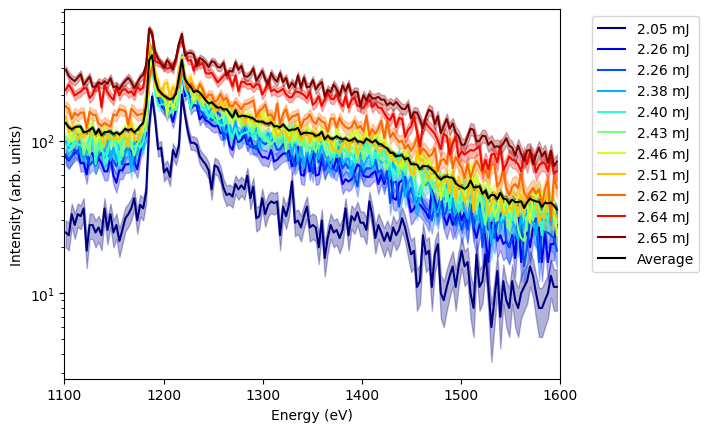

In [49]:
import matplotlib
beam_energies = [2.05, 2.26, 2.26, 2.38, 2.4, 2.43, 2.46, 2.51, 2.62, 2.64, 2.65]

cmap = matplotlib.colormaps["jet"]

# plot uncertainty bands first, then the lines


colours = [cmap(i) for i in np.linspace(0, 1, len(all_spectra))]
for e, spectrum in zip(beam_energies, all_spectra):
    colour = colours.pop(0)
    plt.fill_between(spectrum.bin_centers, spectrum.counts - spectrum.count_uncs, spectrum.counts + spectrum.count_uncs, alpha=0.3, color=colour)

colours = [cmap(i) for i in np.linspace(0, 1, len(all_spectra))]
for e, spectrum in zip(beam_energies, all_spectra):
    colour = colours.pop(0)
    plt.plot(spectrum.bin_centers, spectrum.counts, label=f"{e:.2f} mJ", color=colour)

average_spectrum = np.mean([s.counts for s in all_spectra], axis=0)
N = len(all_spectra)
average_uncs = 1/np.sqrt(N*(N-1)) * np.sqrt(np.sum([(s.count_uncs**2) for s in all_spectra], axis=0))
# average_uncs = np.std([s.counts for s in all_spectra], axis=0)

plt.plot(all_spectra[0].bin_centers, average_spectrum, label="Average", color="black")
plt.fill_between(all_spectra[0].bin_centers, average_spectrum - average_uncs, average_spectrum + average_uncs, alpha=0.3, color="black")

plt.yscale("log")
plt.ylabel("Intensity (arb. units)")
plt.xlabel("Energy (eV)")
plt.xlim(1100,1600)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("all_spectra.pdf", bbox_inches="tight")

# SPC results

## Single and double hits

In [52]:
import pandas as pd

single_hits = [spc.n_single_hits for spc in all_spcs]
double_hits = [spc.n_double_hits for spc in all_spcs]
hit_sizes = [np.mean(spc.all_hit_uncertainties) for spc in all_spcs]

df = pd.DataFrame(
    {
        "Single hits": single_hits,
        "Double hits": double_hits,
        "Hit size": hit_sizes,
        "Beam energy": beam_energies,
    }
)

df["Total hits"] = df["Single hits"] + 2 * df["Double hits"]

df["n1/n2"] = df["Single hits"] / df["Double hits"]

df["Poisson n1/n2"] = 2 * 2048**2 / df["Total hits"]

df

Single hits  Double hits  Hit size  Beam energy  Total hits       n1/n2  \
0         23533          266  1.032634         2.05       24065   88.469925   
1          6421           16  1.058452         2.26        6453  401.312500   
2         16673          119  1.092706         2.26       16911  140.109244   
3         19783          223  1.117640         2.38       20229   88.713004   
4         17767          156  1.138500         2.40       18079  113.891026   
5         13552          127  1.155201         2.43       13806  106.708661   
6         38038         1140  1.152769         2.46       40318   33.366667   
7         16236          214  1.185049         2.51       16664   75.869159   
8         19775          339  1.183941         2.62       20453   58.333333   
9         32628         1045  1.174818         2.64       34718   31.222967   
10        14854          230  1.215931         2.65       15314   64.582609   

    Poisson n1/n2  
0      348.581259  
1     1299.954750  
2      496.044468  
3      414.682288  
4      463.997345  
5      607.605968  
6      208.061114  
7      503.397024  
8      410.140713  
9      241.621292  
10     547.773802

In [57]:
from monte_carlo_circles import monte_carlo

monte_carlo_doubles = [monte_carlo(2048,2048,r, nc, 10) for r, nc in zip(df["Hit size"].values, df["Total hits"].values)]

Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3

In [58]:
monte_carlo_doubles

[[880.9, 32.06384256448376],
 [69.8, 4.812483766206386],
 [497.7, 24.41741182025646],
 [752.8, 20.565991344936425],
 [610.9, 23.556103243108783],
 [375.7, 14.255174499107332],
 [3059.7, 35.983468426487185],
 [575.6, 23.892258160333025],
 [845.8, 32.338212690252384],
 [2384.4, 43.364040402158096],
 [500.7, 18.36872341780996]]

In [60]:
df["Monte Carlo n1/n2"] = (df["Total hits"].values - np.array(monte_carlo_doubles)[:,0]) / np.array(monte_carlo_doubles)[:,0]
df

Single hits  Double hits  Hit size  Beam energy  Total hits       n1/n2  \
0         23533          266  1.032634         2.05       24065   88.469925   
1          6421           16  1.058452         2.26        6453  401.312500   
2         16673          119  1.092706         2.26       16911  140.109244   
3         19783          223  1.117640         2.38       20229   88.713004   
4         17767          156  1.138500         2.40       18079  113.891026   
5         13552          127  1.155201         2.43       13806  106.708661   
6         38038         1140  1.152769         2.46       40318   33.366667   
7         16236          214  1.185049         2.51       16664   75.869159   
8         19775          339  1.183941         2.62       20453   58.333333   
9         32628         1045  1.174818         2.64       34718   31.222967   
10        14854          230  1.215931         2.65       15314   64.582609   

    Poisson n1/n2  Monte Carlo n1/n2  
0      348.581259          26.318651  
1     1299.954750          91.449857  
2      496.044468          32.978300  
3      414.682288          25.871679  
4      463.997345          28.594042  
5      607.605968          35.747405  
6      208.061114          12.177109  
7      503.397024          27.950660  
8      410.140713          23.181840  
9      241.621292          13.560476  
10     547.773802          29.585181

### Comparing in non bragg line regions

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

signal_image_nums = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19]

all_imgs = [np.load(f"data/images/image{i}.npy") for i in signal_image_nums]
restricted_spcs = [SPC(img, 75, 30, 2, padding=2, fit_area_size=5, image_indices=[(0,2040),(0,1100)]) for img in all_imgs]

In [111]:
import pandas as pd

single_hits = np.array([spc.n_single_hits for spc in restricted_spcs])
double_hits = np.array([spc.n_double_hits for spc in restricted_spcs])
total_hits = single_hits + 2 * double_hits
hit_sizes = np.array([np.pi * np.mean(spc.all_hit_uncertainties) for spc in restricted_spcs])
noises = np.array([spc.pedestal_params[2] for spc in restricted_spcs])

df = pd.DataFrame(
    {
        "Beam energy": beam_energies,
        "Number of single hits": single_hits,
        "Number of double hits": double_hits,
        "Calculated $n_1/n_2$": single_hits / double_hits,
        "Predicted $n_1/n_2$": 2 * 2040*1100/hit_sizes / total_hits,
        "Noise SD": noises,
    }
)


df.to_latex(float_format="%.2f", buf="spc_stats.tex", index=False)


In [ ]:

df = pd.DataFrame(
    {
        "Beam energy": beam_energies,
        "Single hits": single_hits,
        "Double hits": double_hits,
        "Hit size": hit_sizes,
        "Noise": noises,
        
    }
)

df["Total hits"] = df["Single hits"] + 2 * df["Double hits"]

df["n1/n2"] = df["Single hits"] / df["Double hits"]

df["Poisson Corrected n1/n2"] = 2 * 2040*1100/df["Hit size"] / df["Total hits"]





df

In [65]:
from monte_carlo_circles import monte_carlo

monte_carlo_doubles = [monte_carlo(2040,1100,r, nc, 10) for r, nc in zip(df["Hit size"].values, df["Total hits"].values)]

Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3/10
Trial: 4/10
Trial: 5/10
Trial: 6/10
Trial: 7/10
Trial: 8/10
Trial: 9/10
Trial: 10/10
Trial: 1/10
Trial: 2/10
Trial: 3

In [66]:
df["Monte Carlo n1/n2"] = (df["Total hits"].values - 2*np.array(monte_carlo_doubles)[:,0]) / np.array(monte_carlo_doubles)[:,0]
df

Single hits  Double hits  Hit size  Beam energy  Total hits       n1/n2  \
0         12804          159  1.024328         2.05       13122   80.528302   
1          2920            3  1.024534         2.26        2926  973.333333   
2          8649           51  1.074333         2.26        8751  169.588235   
3         10342          102  1.100873         2.38       10546  101.392157   
4          9080           70  1.120659         2.40        9220  129.714286   
5          6429           43  1.118900         2.43        6515  149.511628   
6         20803          636  1.144151         2.46       22075   32.709119   
7          7812           88  1.155292         2.51        7988   88.772727   
8          9851          152  1.163089         2.62       10155   64.809211   
9         17190          580  1.161269         2.64       18350   29.637931   
10         6845          100  1.186957         2.65        7045   68.450000   

    Poisson n1/n2  Monte Carlo n1/n2  
0      342.021033          24.535895  
1     1533.834586         114.111111  
2      512.855674          34.799832  
3      425.564195          26.940724  
4      486.767896          28.469266  
5      688.871834          44.870504  
6      203.306908          10.871720  
7      561.842764          31.919321  
8      441.949778          24.233531  
9      244.577657          13.131525  
10     637.047551          34.146742

# Monte carlo test

In [92]:
def count_double_hits(Lx, Ly, n_pix, n_c):

    # If the average hit extent is n_pix, then the probability of a hit spanning 
    # floor(n_pix) pixels is n_pix - floor(n_pix) and the probability of a hit spanning
    # ceil(n_pix) pixels is ceil(n_pix) - n_pix.

    grid = np.zeros((Lx, Ly))

    shapes = [
        [(0,0)],
        [(0,0), (0,1)],
        [(0,0), (0,1), (1,0)],
        [(0,0), (0,1), (1,0), (1,1)]
    ]

    for i in range(n_c):
        size = 


def monte_carlo(Lx, Ly, r, n_c, n_trials, verbose=0):

    double_hits = np.zeros(n_trials)

    for i in range(n_trials):
        if verbose >= 2:
            print(f"Trial: {i+1}/{n_trials}")
        double_hits[i] = count_double_hits(Lx, Ly, r, n_c)

    if verbose >= 1:
        print(
            f"Mean double hits: {double_hits.mean()}, Standard deviation: {double_hits.std()}"
        )

    return [double_hits.mean(), double_hits.std()]

In [95]:

N = 100**2
n_hits = 1000

n2_mc, n2_mc_var = monte_carlo(int(np.sqrt(N)), int(np.sqrt(N)), 0.5, n_hits, 100)

print(f"Monte Carlo n1/n2 = {(n_hits-2*n2_mc)/n2_mc}")
print(f"Min value = {(n_hits-2*n2_mc-n2_mc_var)/(n2_mc+n2_mc_var)}")
print(f"Min value = {(n_hits-2*n2_mc+n2_mc_var)/(n2_mc-n2_mc_var)}")

print(f"Monte Carlo hits per pixel")
n2_mc

Monte Carlo n1/n2 = 5.033832735457552
Min value = 4.65008095679879
Min value = 5.47351167804486


142.17

In [94]:

print(f"Poisson n1/n2 = {2*N/n_hits}")

Poisson n1/n2 = 20.0


# Bragg map stuff

## Uncertainties

In [7]:
master_em.hyp_params, master_em.hyp_uncertainties

(array([-1.83481748e+03,  8.38889310e+02,  1.41793672e+07,  4.69718247e-01]),
 array([1.75939592e+01, 1.03337614e+01, 1.44265111e+05, 4.74243473e-03]))

These propagate to uncertainties in the energy scale:

In [114]:
import sympy

E_vals, k, D2, Ys, y, yc, x, xc = sympy.symbols("E k D2 Ys y yc x xc")

E_vals = k * sympy.sqrt(1 + (D2 + Ys * (y - yc) ** 2) / ((x - xc) ** 2))

dEdxc = sympy.diff(E_vals, xc)
dEdyc = sympy.diff(E_vals, yc)
dEdD2 = sympy.diff(E_vals, D2)
dEdYs = sympy.diff(E_vals, Ys)

dEdxc, dEdyc, dEdD2, dEdYs

(k*(D2 + Ys*(y - yc)**2)/((x - xc)**3*sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)),
 Ys*k*(-2*y + 2*yc)/(2*(x - xc)**2*sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)),
 k/(2*(x - xc)**2*sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)),
 k*(y - yc)**2/(2*(x - xc)**2*sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

signal_image_nums = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19]

all_imgs = [np.load(f"data/images/image{i}.npy") for i in signal_image_nums]
all_spcs = [SPC(img, 75, 30, 2, padding=2, fit_area_size=5) for img in all_imgs]


Uncertainties due to peak uncertainties: [ 1.23339757e+02 -7.24768114e+01 -1.00977301e+06  2.96461664e-02]
Uncertainties due to fitting process: [2.30075774e+00 1.31486188e+00 2.04839310e+04 2.21647998e-03]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap, Spectrum

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)
master_em = EnergyMap(spc.img, 200, 200, 20, 2, 100, 25, [1218.5, 1188.0])

Uncertainties due to peak uncertainties: [ 1.74428757e+01 -1.02497690e+01 -1.42803469e+05  4.19260106e-03]
Uncertainties due to fitting process: [2.30075774e+00 1.31486188e+00 2.04839310e+04 2.21647998e-03]


In [4]:
spectrum = Spectrum(spc, master_em, 3, 1100, 1600)

In [25]:
x, y = np.meshgrid(np.linspace(0,2048,200), np.linspace(0,2048,200))

sys_uncs = spectrum.systematic_sigma_E(x, y)
energies = np.zeros_like(x)
for i in range(len(x)):
    for j in range(len(y)):
        energies[i,j] = master_em.calculate_energy((x[0,i],y[j,0]))

energies = energies.mean(axis=0)
sys_uncs = sys_uncs.mean(axis=0)

sys_uncs = sys_uncs[np.logical_and(energies < 1600, energies > 1100)]
energies = energies[np.logical_and(energies < 1600, energies > 1100)]

energies, sys_uncs


(array([1595.35670615, 1589.46017045, 1583.62728586, 1577.85711222,
        1572.14872738, 1566.50122676, 1560.91372292, 1555.38534518,
        1549.9152392 , 1544.50256661, 1539.14650466, 1533.84624583,
        1528.60099751, 1523.40998163, 1518.27243434, 1513.1876057 ,
        1508.15475935, 1503.17317222, 1498.24213421, 1493.36094793,
        1488.5289284 , 1483.74540278, 1479.00971011, 1474.32120103,
        1469.67923757, 1465.08319285, 1460.53245089, 1456.02640633,
        1451.56446424, 1447.14603988, 1442.77055848, 1438.43745507,
        1434.14617419, 1429.89616979, 1425.68690495, 1421.51785175,
        1417.38849106, 1413.29831234, 1409.2468135 , 1405.23350071,
        1401.25788824, 1397.31949826, 1393.41786074, 1389.55251325,
        1385.72300082, 1381.92887581, 1378.16969772, 1374.44503308,
        1370.75445534, 1367.09754466, 1363.47388784, 1359.88307818,
        1356.32471532, 1352.79840516, 1349.30375972, 1345.84039704,
        1342.40794101, 1339.00602134, 1335.63427

In [11]:
y

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [ 107.78947368,  107.78947368,  107.78947368,  107.78947368,
         107.78947368,  107.78947368,  107.78947368,  107.78947368,
         107.78947368,  107.78947368,  107.78947368,  107.78947368,
         107.78947368,  107.78947368,  107.78947368,  107.78947368,
         107.78947368,  107.78947368,  107.78947368,  107.78947368],
       [ 215.57894737,  215.57894737,  215.57894737,  215.57894737,
         215.57894737,  215.57894737,  215.57894737,  215.57894737,
         215.57894737,  215.57894737,  215.57894737,  215.57894737,
         215.57894737,  215.57894737,  215.57894737,  215.57894737,
         215.57894737,  215.57894737,  215.578

In [15]:
y[:, 0]

array([   0.        ,  107.78947368,  215.57894737,  323.36842105,
        431.15789474,  538.94736842,  646.73684211,  754.52631579,
        862.31578947,  970.10526316, 1077.89473684, 1185.68421053,
       1293.47368421, 1401.26315789, 1509.05263158, 1616.84210526,
       1724.63157895, 1832.42105263, 1940.21052632, 2048.        ])

# Comparing the magnitude of uncertainties in intensity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap, Spectrum

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)
master_em = EnergyMap(spc.img, 200, 200, 20, 2, 100, 25, [1218.5, 1188.0])

Uncertainties due to peak uncertainties: [ 1.74428757e+01 -1.02497690e+01 -1.42803469e+05  4.19260106e-03]
Uncertainties due to fitting process: [2.30075774e+00 1.31486188e+00 2.04839310e+04 2.21647998e-03]


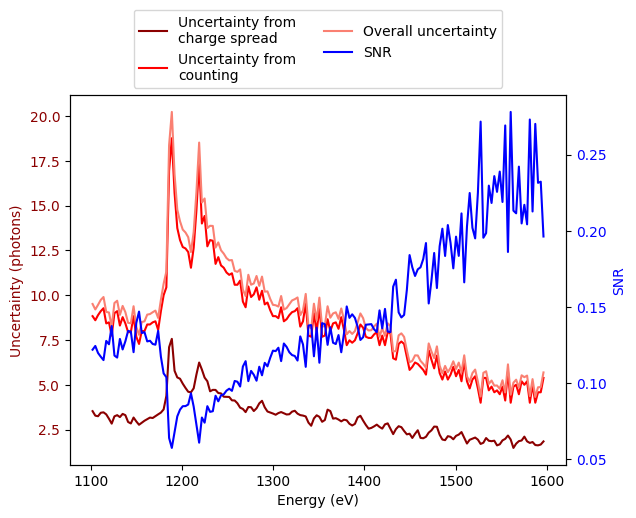

In [56]:
spectrum = Spectrum(spc, master_em, 3, 1100, 1600)

fig, ax1 = plt.subplots()

ln1 = ax1.plot(spectrum.bin_centers, spectrum.energy_count_uncs, label = "Uncertainty from\ncharge spread", color="darkred")
ln2 = ax1.plot(spectrum.bin_centers, spectrum.poisson_uncs, label="Uncertainty from\ncounting", color="red")
ln3 = ax1.plot(spectrum.bin_centers, spectrum.count_uncs, label = "Overall uncertainty", color="salmon")

ax2 = ax1.twinx()

ln4 = ax2.plot(spectrum.bin_centers, spectrum.count_uncs/spectrum.counts, label = "SNR", color="blue")

lns = ax1.lines

lns += ax2.lines

labs = [l.get_label() for l in lns]

ax2.legend(lns, labs, loc='upper center', ncol=2, bbox_to_anchor=(0.5,1.25))

ax1.set_ylabel("Uncertainty (photons)", color="darkred")
ax1.set_xlabel("Energy (eV)")
ax1.tick_params(axis="y", labelcolor="darkred")
ax2.set_ylabel("SNR",color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

#fig.tight_layout()
plt.savefig("uncertainty_graph.pdf", bbox_inches="tight")


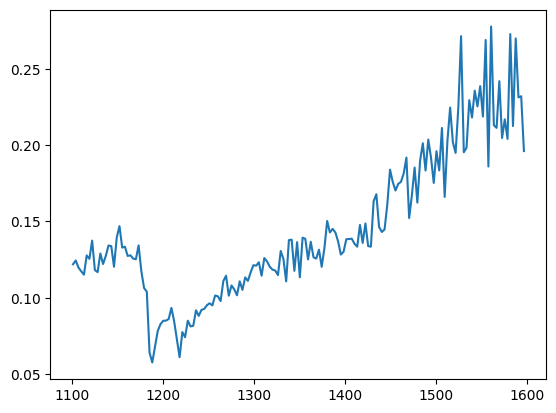

In [4]:
plt.plot(spectrum.bin_centers, spectrum.count_uncs/spectrum.counts)